In [1]:
%matplotlib inline

from functools import partial
from itertools import chain, product

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import ZeroInput

from hippocampus import HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY, HippocampalCA3Node
from utils import run_in_parallel

plt.style.use("default_light")

In [3]:
def compute_wrt_connectivity(w, w_position, init_conds):
    results = []
    for init_c in init_conds:
        conn_tmp = HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY.copy()
        conn_tmp[w_position] = w * 1e3  # scale since we use kHz
        hc = HippocampalCA3Node(
            connectivity=conn_tmp, aswr_mass_type="constant_depression"
        )
        for mass in hc:
            mass._noise_input = [ZeroInput()]
        m = MultiModel.init_node(hc)
        if init_c == 0:
            # SWR state
            m.model_instance.initial_state = np.array([0.044, 0.092, 0.0])
        else:
            # non-SWR state
            m.model_instance.initial_state = np.array([0.0, 0.0, 0.0125])
        m.params["backend"] = "numba"
        m.params["duration"] = 2000
        m.params["dt"] = 0.05
        m.params["*aSWR*e|noise"] = 0.5
        m.run()
        arr = xr.DataArray(
            np.array(
                [
                    float(m.r_mean_EXC.T[-1]),
                    float(m.r_mean_INH.T[-1]),
                    float(m.r_mean_aSWR.T[-1]),
                ]
            ),
            dims=["node"],
            coords={"node": ["P", "B", "A"]},
        ).assign_coords(
            {
                "connectivity": w,
                "to": w_position[0],
                "from": w_position[1],
                "init_c": init_c,
            }
        )
        results.append(arr)

    return results

In [4]:
connections = np.linspace(0.0, 15.0, 151)
to_nodes = [0, 1, 2]
from_nodes = [0, 1, 2]
init_conds = [0.0, 1.0]


def parallel_wrapper(args):
    conn, to_, from_ = args
    return compute_wrt_connectivity(
        w=conn, w_position=(to_, from_), init_conds=init_conds
    )


res = run_in_parallel(
    parallel_wrapper, list(product(connections, to_nodes, from_nodes)), workers=6
)

bif_wrt_conn = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["connectivity", "init_c", "to", "from"])
    .unstack("new")
)

100%|██████████| 1359/1359 [07:49<00:00,  2.89it/s]


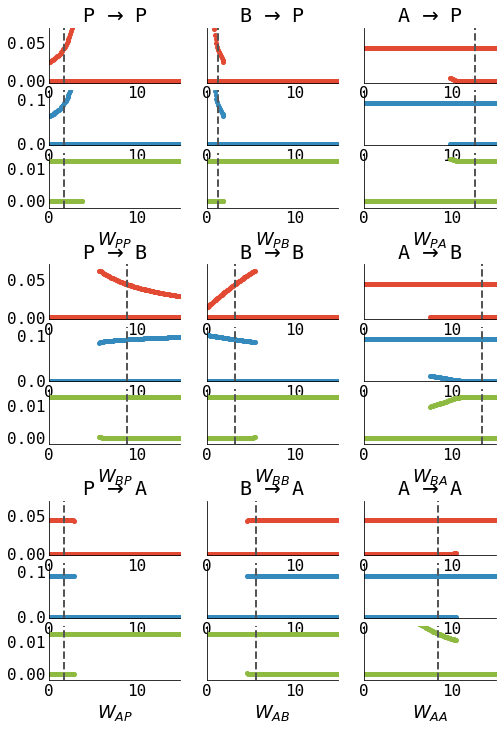

In [6]:
fig, axs = plt.subplots(
    nrows=11,
    ncols=3,
    figsize=(8, 12),
    sharex=False,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 1, 1, 0.75, 1, 1, 1, 0.75, 1, 1, 1]},
)
for i in range(3):
    axs[3, i].axis("off")
    axs[7, i].axis("off")

nodes = {0: "P", 1: "B", 2: "A"}
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for tt in bif_wrt_conn["to"]:
    for ff in bif_wrt_conn["from"]:
        for ii, node in enumerate(bif_wrt_conn["node"]):
            ax = axs[tt * 4 + ii, ff]
            ax.plot(
                bif_wrt_conn["connectivity"].values,
                bif_wrt_conn.sel({"node": node, "to": tt, "from": ff}),
                "o",
                color=colors[ii],
                markersize=4,
            )
            ax.set_xlim([0, 15])
            ax.set_ylim([-0.002, maxs[ii]])
            # ax.set_ylabel(f"{node.values} [kHz]")
            ax.axvline(
                HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY[int(tt), int(ff)] / 1000.0,
                linestyle="--",
                color="#555555",
            )
            sns.despine(ax=ax)
            if ii == 2:
                ax.set_xlabel(
                    fr"$W_{{{nodes[int(tt.values)]}{nodes[int(ff.values)]}}}$"
                )
            if ii == 0:
                ax.set_title(fr"{nodes[int(ff.values)]} $\to$ {nodes[int(tt.values)]}")

plt.subplots_adjust(hspace=0.15, wspace=0.2)
plt.savefig("../figs/bifurcation_wrt_w.pdf", transparent=True, bbox_inches="tight")